In [1]:
from astrometry.util.fits import *
import pylab as plt
import numpy as np
from glob import glob
from astrometry.util.starutil_numpy import *
from collections import Counter
from datetime import datetime
from astropy import units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, get_body, get_sun
from astropy.time import Time

In [2]:
import diet

In [3]:
# Jean-Charles pointed me to these log files from CFIS-r and CFIS-u:
# https://www.cfht.hawaii.edu/Science/CFHTLS-DATA/exposurescatalogs.html
lines = (
    open('MCLOG-CFIS.r.qso-elx.log').readlines() +
    open('MCLOG-CFIS.u.qso-elx.log').readlines()
)
len(lines)

45197

In [4]:
# And then there's CFHTLS ...
# https://www.cfht.hawaii.edu/Science/CFHTLS-DATA/exposureslogs.html
cfhtls_lines = (
    open('CFHTLS-Deep.log').readlines() +
    open('CFHTLS-Wide.log').readlines() +
    open('CFHTLS-VeryWide.log').readlines()
)
len(cfhtls_lines)

25564

In [5]:
def parse_logs(lines):
    T = fits_table()
    T.expnum = []
    T.obsdate = []
    T.ra_hms = []
    T.dec_dms = []
    T.exptime = []
    T.filter = []
    T.airmass = []
    T.seeing_center = []
    T.seeing_outer = []
    T.skylevel = []
    T.photometric = []

    for line in lines:
        try:
            words = line.split('|')
            words = [w.strip() for w in words]
            w = words[1].split()
            obsdate = ' '.join(w[1:])
            w = words[3].split()
            x = words[7].split()
            y = words[8].split()
            [float(xi) for xi in x[:2]]
            T.expnum.append(int(words[0]))
            T.obsdate.append(obsdate)
            T.ra_hms.append(w[0])
            T.dec_dms.append(w[1])
            T.exptime.append(int(words[4]))
            T.filter.append(words[5])
            T.airmass.append(float(words[6]))
            T.seeing_center.append(float(x[0]))
            T.seeing_outer.append(float(x[1]))
            T.skylevel.append(float(x[2]))
            T.photometric.append(y[0])
        except:
            print('Line:', line.strip())
    T.to_np_arrays()
    # NOTE -- this is HAWAII time, not UTC!!!
    T.date = np.array([datetime.strptime(t, '%b %d %H:%M:%S %y') for t in T.obsdate])
    T.mjd = np.array([datetomjd(d) for d in T.date])
    #T.about()
    T.ra = np.array([hmsstring2ra(r) for r in T.ra_hms])
    T.dec = np.array([dmsstring2dec(d) for d in T.dec_dms])
    return T

In [6]:
T = parse_logs(lines)

In [7]:
T_cfhtls = parse_logs(cfhtls_lines)

Line: 700362 |        Apr 30 02:50:56 03 | E99 Zenith     | 16:38:58.6  20:07:15 2000 |   15 | r | 1.00 |
Line: 760665 | 04BQ02 Sep 05 22:46:13 04 | L01 D4         | 22:15:31.7 -17:44:04 2000 |  360 | z | 1.30 | IQ =     0 |P 1 V Q|
Line: 760666 | 04BQ02 Sep 05 22:53:03 04 | L01 D4         | 22:15:30.2 -17:44:34 2000 |  360 | z | 1.29 | IQ =     0 |P 1 V Q|
Line: 760667 | 04BQ02 Sep 05 22:59:53 04 | L01 D4         | 22:15:32.3 -17:45:34 2000 |  360 | z | 1.28 | IQ =     0 |P 1 V Q|
Line: 760668 | 04BQ02 Sep 05 23:06:42 04 | L01 D4         | 22:15:33.2 -17:43:34 2000 |  360 | z | 1.28 | IQ =     0 |P 1 V Q|
Line: 760669 | 04BQ02 Sep 05 23:13:32 04 | L01 D4         | 22:15:31.1 -17:42:34 2000 |  360 | z | 1.27 | IQ =     0 |P 1 V Q|
Line: 760670 | 04BQ02 Sep 05 23:20:21 04 | L01 D4         | 22:15:30.6 -17:43:04 2000 |  360 | z | 1.27 | IQ =     0 |P 1 V Q|
Line: 760671 | 04BQ02 Sep 05 23:27:11 04 | L01 D4         | 22:15:32.7 -17:45:04 2000 |  360 | z | 1.26 | IQ =     0 |P 1 V Q|
Line:

In [8]:
Counter(T.filter)

Counter({np.str_('u'): 24376, np.str_('r'): 20821})

In [9]:
colormap = dict(g='g', r='r', u='b', i='m', z='k')

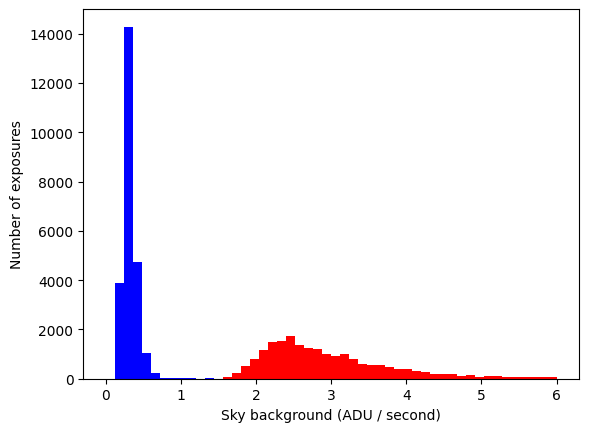

In [10]:
kwa = dict(range=(0, 6), bins=50)
I = np.flatnonzero(T.filter == 'u')
plt.hist(T.skylevel[I] / T.exptime[I], color='b', **kwa)
I = np.flatnonzero(T.filter == 'r')
plt.hist(T.skylevel[I] / T.exptime[I], color='r', **kwa)
plt.xlabel('Sky background (ADU / second)')
plt.ylabel('Number of exposures');
#plt.title('CFHT 2023, g band exposures');
# From diet.py, and J-C's gain=1.5 number
#plt.axvline(3.34 / 1.5, color='r')


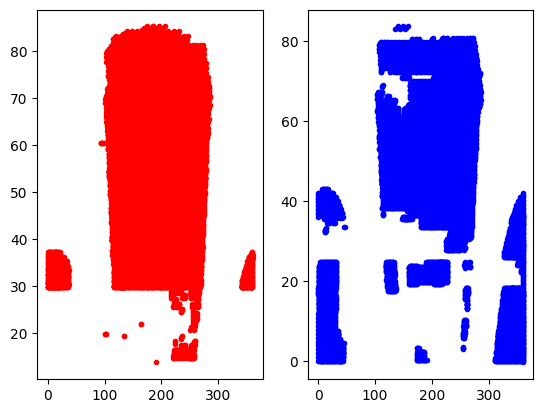

In [11]:
plt.subplot(1,2,1)
I = np.flatnonzero(T.filter == 'r')
plt.plot(T.ra[I], T.dec[I], 'r.')
plt.subplot(1,2,2)
I = np.flatnonzero(T.filter == 'u')
plt.plot(T.ra[I], T.dec[I], 'b.');

In [12]:
# Plot seeing quantiles by year
T_cfhtls.year = 2000 + np.array([int(d[-2:]) for d in T_cfhtls.obsdate])
T.year = 2000 + np.array([int(d[-2:]) for d in T.obsdate])

In [13]:
Counter(T_cfhtls.year)

Counter({np.int64(2005): 6292,
         np.int64(2006): 4727,
         np.int64(2004): 4336,
         np.int64(2007): 4136,
         np.int64(2008): 3248,
         np.int64(2003): 2649,
         np.int64(2009): 154})

In [14]:
Counter(T.year)

Counter({np.int64(2017): 10317,
         np.int64(2021): 6784,
         np.int64(2018): 6782,
         np.int64(2019): 4782,
         np.int64(2025): 4594,
         np.int64(2020): 4210,
         np.int64(2022): 3271,
         np.int64(2023): 2489,
         np.int64(2024): 1968})

In [15]:
T.cut(np.isfinite(T.seeing_center))

In [16]:
T_cfhtls.cut(np.isin(T_cfhtls.filter, ['u','g','r','i','z']))
len(T_cfhtls)

25528

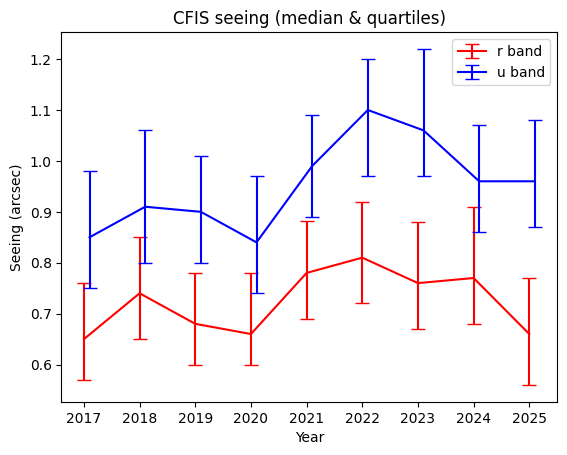

In [17]:
Tx = T
#Tx = T_cfhtls
for i,f in enumerate(np.unique(Tx.filter)):
    qq = []
    years = np.unique(Tx.year)
    yy = []
    for y in years:
        I = np.flatnonzero((Tx.year == y) * (Tx.filter == f))
        if len(I) == 0:
            continue
        #print(len(I), 'in filter', f, 'year', y)
        q = np.percentile(Tx.seeing_center[I], [25,50,75])
        qq.append(q)
        yy.append(y)
    qq = np.vstack(qq)
    plt.errorbar(np.array(yy)+0.1*i, qq[:,1], yerr=np.abs(qq[:,np.array([0,2])]-qq[:,1][:,np.newaxis]).T,
                 capsize=5, color=colormap[f], label='%s band' % f)
    #plt.plot(years, qq, '-', color=colormap[f])
plt.legend()
plt.xlabel('Year')
plt.ylabel('Seeing (arcsec)')
plt.title('CFIS seeing (median & quartiles)')
plt.savefig('cfis-seeing.png')

In [45]:
def recompute_moon(T):
    # Recompute moon altitude (and object altitude -> airmass)
    utcoffset = -10 * u.hour  # EDT
    obs = EarthLocation.of_site('cfht')
    #T.moon_alt = np.zeros(len(T), np.float32)
    #T.obj_alt = np.zeros(len(T), np.float32)
    #for i,(mjd,ra,dec) in enumerate(zip(T.mjd, T.ra, T.dec)):
    #    time = Time(mjd, format='mjd') - utcoffset
    #    moon = get_body('moon', time)
    #    altaz = AltAz(obstime=time, location=obs)
    #    moon_altaz = moon.transform_to(altaz)
    #    obj = SkyCoord(ra, dec, unit='deg')
    #    obj_altaz = obj.transform_to(altaz)
    #    T.moon_alt[i] = moon_altaz.alt.deg
    #    T.obj_alt[i] = obj_altaz.alt.deg
    times = Time(T.mjd, format='mjd') - utcoffset
    altaz = AltAz(obstime=times, location=obs)
    moon = get_body('moon', times)
    obj = SkyCoord(T.ra, T.dec, unit='deg')
    moon_altaz = moon.transform_to(altaz)
    obj_altaz = obj.transform_to(altaz)
    T.moon_alt = moon_altaz.alt.deg
    T.obj_alt = obj_altaz.alt.deg

In [ ]:
recompute_moon(T)

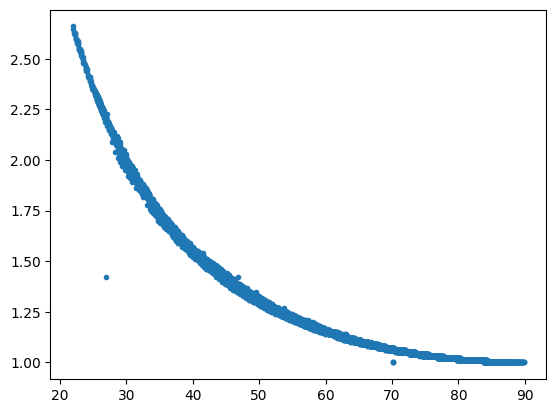

In [19]:
# Verify object alt vs airmass... not perfect agreement, but ok.  Daylight saving time?
plt.plot(T.obj_alt, T.airmass, '.');

In [20]:
I = np.flatnonzero(T.filter == 'r')
print('r dark', Counter(T.moon_alt[I] < 0))

I = np.flatnonzero(T.filter == 'g')
print('g dark', Counter(T.moon_alt[I] < 0))

I = np.flatnonzero(T.filter == 'u')
print('u dark', Counter(T.moon_alt[I] < 0))

r dark Counter({np.True_: 17279, np.False_: 3539})
g dark Counter()
u dark Counter({np.True_: 22714, np.False_: 1662})


In [21]:
Tmoon = T[T.moon_alt > 0]

In [22]:
T.cut(T.moon_alt < 0)
len(T)

39993

In [23]:
T.cut(T.skylevel > 0)

In [24]:
T.cut(T.exptime >= 60)

In [25]:
T.cut(np.isfinite(T.seeing_center))

In [26]:
mjdtodate(T.mjd.min()), mjdtodate(T.mjd.max())

(datetime.datetime(2017, 1, 24, 4, 12, 19, 1),
 datetime.datetime(2025, 9, 21, 19, 39, 2, 999992))

In [27]:
gain = diet.mp_config['gain']

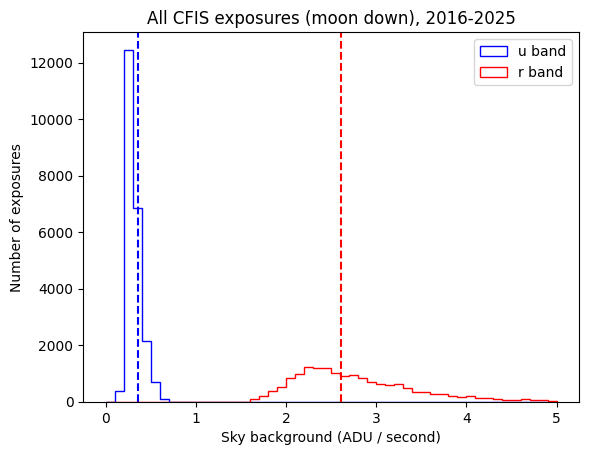

In [28]:
kwa = dict(range=(0, 5), bins=50, histtype='step')
I = np.flatnonzero(T.filter == 'u')
plt.hist(T.skylevel[I] / T.exptime[I], color='b', label='u band', **kwa)
medu = np.median(T.skylevel[I] / T.exptime[I])
plt.axvline(diet.dark_sky['u'] / gain, color='b', linestyle='--')
if 'g' in np.unique(T.filter):
    I = np.flatnonzero(T.filter == 'g')
    plt.hist(T.skylevel[I] / T.exptime[I], color='g', label='g band', lw=3, **kwa)
    medg = np.median(T.skylevel[I] / T.exptime[I])
    plt.axvline(diet.dark_sky['g'] / gain, color='g', linestyle='--')
I = np.flatnonzero(T.filter == 'r')
plt.hist(T.skylevel[I] / T.exptime[I], color='r', label='r band', **kwa)
plt.axvline(diet.dark_sky['r'] / gain, color='r', linestyle='--')
medr = np.median(T.skylevel[I] / T.exptime[I])
plt.xlabel('Sky background (ADU / second)')
plt.ylabel('Number of exposures');
plt.title('All CFIS exposures (moon down), 2016-2025')
#plt.title('All CFHTLS exposures (moon down), 2003-2009')
plt.legend();
#plt.yscale('log')

In [22]:
# From  https://www.cfht.hawaii.edu/Instruments/Imaging/MegaPrime/observingstats.html
# Filter 	                      u* 	g' 	     r' 	i' 	     z'
# Sky level in ADU/sec 	        0.56 	2.81 	3.97 	6.76 	6.69
# Sky level in mag / arcsec^2 	22.2 	21.7 	20.8 	20.0 	19.1

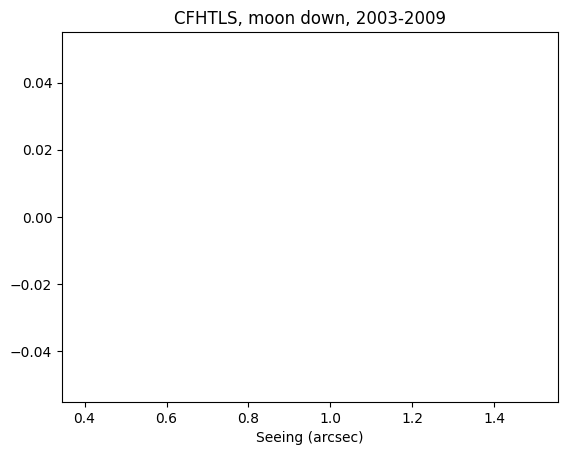

In [29]:
I = np.flatnonzero(T.filter == 'g')
plt.hist(T.seeing_center[I], range=(0.4, 1.5), bins=30, color='g');
plt.title('CFHTLS, moon down, 2003-2009')
plt.xlabel('Seeing (arcsec)');

In [30]:
#Counter(T.photometric)

In [31]:
Tg = T[T.filter == 'g']
len(Tg)

0

In [32]:
mag = 25.0
airmass = 1.2
gain = diet.mp_config['gain']
n_splits = 4.

nom_seeing = 0.75
#g_nom_sky = diet.dark_sky['g']

mb_nom_sky = dict([(mb, diet.dark_sky[mb]) for mb in ['mb1', 'mb2']])

def exptime(filter, sky, seeing):
    tt = diet.psfexptime(snr=5.0 / np.sqrt(n_splits),
                         mAB=mag,
                         fluxormag='mag',
                         am=airmass,
                         trans=1.0,
                         gain=gain,
                         sky=sky,
                         filter=filter,
                         seeing=seeing)
    return tt()

mb = 'mb1'
t_nom_mb1 = exptime(mb, diet.dark_sky[mb], nom_seeing)
mb = 'mb2'
t_nom_mb2 = exptime(mb, diet.dark_sky[mb], nom_seeing)
print()
print('Nominal exposure time in', mb, ': %.1f' % t_nom_mb1)
print('Nominal exposure time in', mb, ': %.1f' % t_nom_mb2)

Pixel stddev due to sky       : 5.6 ADU
Pixel stddev due to read-noise: 3.1 ADU
Pixel stddev due to sky       : 5.9 ADU
Pixel stddev due to read-noise: 3.1 ADU

Nominal exposure time in mb2 : 192.2
Nominal exposure time in mb2 : 186.2


In [27]:
T.exptime_mb1 = np.zeros(len(T), np.float32)
T.exptime_mb2 = np.zeros(len(T), np.float32)
for i,(seeing,sky_adu,filt) in enumerate(zip(T.seeing_center, T.skylevel / T.exptime, T.filter)):
    sky = sky_adu * gain
    rel_sky = sky / diet.dark_sky[filt]
    sky = mb_nom_sky['mb1'] * rel_sky
    T.exptime_mb1[i] = exptime('mb1', sky, seeing)
    sky = mb_nom_sky['mb2'] * rel_sky
    T.exptime_mb2[i] = exptime('mb2', sky, seeing)

In [28]:
# RGB Color map
def norm(*c):
    c = np.array(c)
    return np.array([1, 0.8, 1]) * c / np.sum(c)
cc = dict(M411=norm(124/255,0,222/255),
          M438=norm(23/255, 0, 255/255),
          M464=norm(0, 142/255, 255/255),
          M490=norm(0, 255/255, 255/255),
          M517=norm(36/255, 255/255, 0),
         )
cc['mb1'] = cc['M411']
cc['mb2'] = cc['M438']

In [29]:
i = np.flatnonzero(T.exptime_mb1 == 0)

In [30]:
T.seeing_center[i]

array([], dtype=float64)

In [31]:
Counter(np.isfinite(T.seeing_center))

Counter({np.True_: 38846})

In [32]:
Counter(T.filter)

Counter({np.str_('u'): 22633, np.str_('r'): 16213})

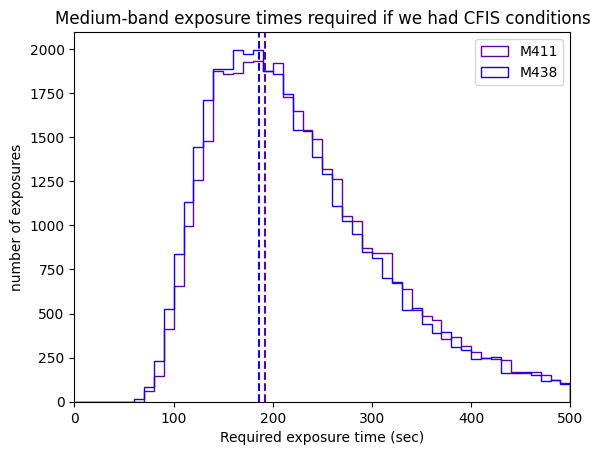

In [43]:
color = cc['mb1']
plt.hist(T.exptime_mb1, range=(0,500), bins=50, histtype='step', color=color, label='M411');
plt.axvline(t_nom_mb1, color=color, linestyle='--');

color = cc['mb2']
plt.hist(T.exptime_mb2, range=(0,500), bins=50, histtype='step', color=color, label='M438');
plt.axvline(t_nom_mb2, color=color, linestyle='--');
plt.xlim(0, 500)
plt.legend()
plt.xlabel('Required exposure time (sec)');
plt.ylabel('number of exposures')
plt.title('Medium-band exposure times required if we had CFIS conditions')
plt.savefig('mb-exptime.png')
#plt.yscale('log')

In [44]:
pwd

'/global/u1/d/dstn/cfht-etc'

In [45]:
speed1 = np.median(t_nom_mb1 / T.exptime_mb1)
speed2 = np.median(t_nom_mb2 / T.exptime_mb2)
speed1, speed2

(np.float32(0.8866551), np.float32(0.88690203))

In [46]:
# Exptime-weighted speed
speed = np.sum(T.exptime * t_nom_mb1 / T.exptime_mb1) / np.sum(T.exptime)

In [47]:
speed

np.float64(0.9542390237980887)

In [48]:
# Exptime-weighted speed
I = np.flatnonzero(T.filter == 'u')
speed = np.sum(T.exptime[I] * t_nom_mb1 / T.exptime_mb1[I]) / np.sum(T.exptime[I])
print('Average speed of u-band:', speed)
I = np.flatnonzero(T.filter == 'r')
speed = np.sum(T.exptime[I] * t_nom_mb1 / T.exptime_mb1[I]) / np.sum(T.exptime[I])
print('Average speed of r-band:', speed)

Average speed of u-band: 0.8269509338658909
Average speed of r-band: 1.0510515392606015


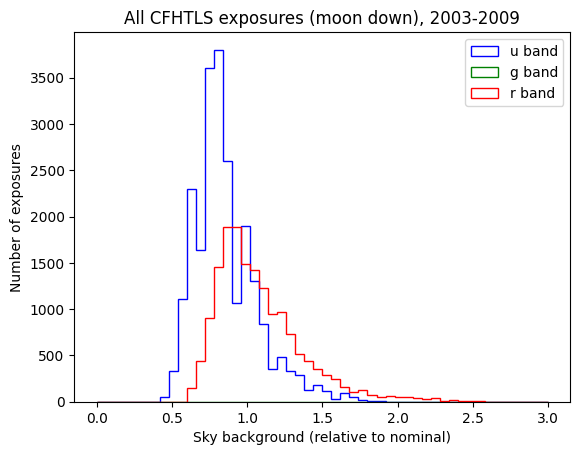

In [41]:
# How do the variations of the u,g,r-band skies vary around their nominals?
kwa = dict(range=(0, 3), bins=50, histtype='step')
I = np.flatnonzero(T.filter == 'u')
plt.hist(T.skylevel[I] / T.exptime[I] / (diet.dark_sky['u']/gain), color='b', label='u band', **kwa)
I = np.flatnonzero(T.filter == 'g')
plt.hist(T.skylevel[I] / T.exptime[I] / (diet.dark_sky['g']/gain), color='g', label='g band', **kwa)
I = np.flatnonzero(T.filter == 'r')
plt.hist(T.skylevel[I] / T.exptime[I] / (diet.dark_sky['r']/gain), color='r', label='r band', **kwa)
plt.xlabel('Sky background (relative to nominal)')
plt.ylabel('Number of exposures');
plt.title('All CFHTLS exposures (moon down), 2003-2009')
plt.legend();

Median in u: 0.93
Median in r: 0.71


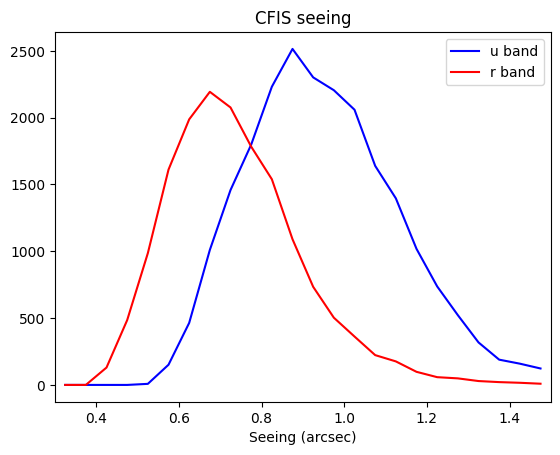

In [65]:
colormap = dict(g='g', r='r', u='b')
for f in ['u','r']:
    I = np.flatnonzero((T.filter == f) * (T.seeing_center < 1.5))
    med = np.median(T.seeing_center[I])
    print('Median in %s: %.2f' % (f, med))
    n,e = np.histogram(T.seeing_center[I], range=(0.3, 1.5), bins=24)
    plt.plot((e[1:]+e[:-1])/2, n, '-', color=colormap[f], label='%s band' % f)
    #plt.hist(T.seeing_center[I], range=(0.4, 1.5), bins=22, color=colormap[f], histtype='step', label='%s band' % f);
    #plt.title('CFHTLS, moon down, 2003-2009')
    plt.xlabel('Seeing (arcsec)');
plt.xlim(0.3, 1.5)
plt.title('CFIS seeing')
plt.legend()
plt.savefig('cfis-seeing.png');

In [46]:
recompute_moon(T_cfhtls)

25528

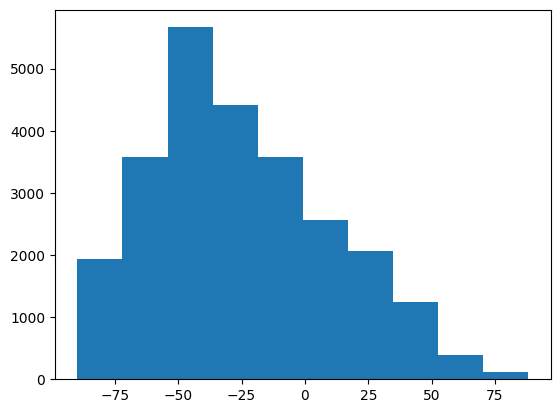

In [50]:
plt.hist(T_cfhtls.moon_alt);
len(T_cfhtls)

In [51]:
T_cfhtls.cut(T_cfhtls.moon_alt < 0)
len(T_cfhtls)

19288

In [52]:
Counter(T_cfhtls.filter)

Counter({np.str_('i'): 5434,
         np.str_('r'): 5340,
         np.str_('g'): 4644,
         np.str_('z'): 2471,
         np.str_('u'): 1399})

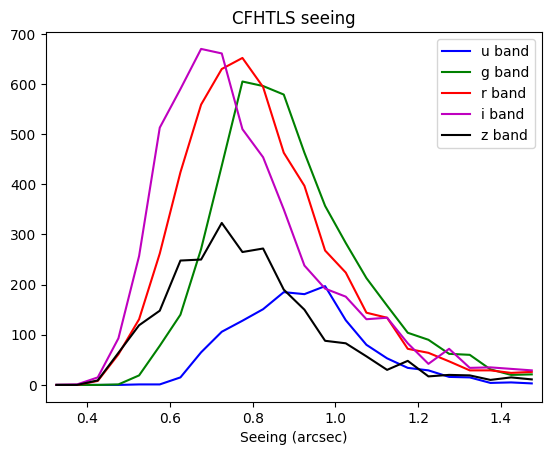

In [53]:
for f in ['u','g','r','i','z']:
    I = np.flatnonzero(T_cfhtls.filter == f)
    n,e = np.histogram(T_cfhtls.seeing_center[I], range=(0.3, 1.5), bins=24)
    plt.plot((e[1:]+e[:-1])/2, n, '-', color=colormap[f], label='%s band' % f)
    #plt.hist(T_cfhtls.seeing_center[I], range=(0.4, 1.5), bins=22, color=colormap[f], histtype='step', label='%s band' % f);
    #plt.title('CFHTLS, moon down, 2003-2009')
    plt.xlabel('Seeing (arcsec)');
plt.xlim(0.3, 1.5)
plt.title('CFHTLS seeing')
plt.legend()
plt.savefig('cfhtls-seeing.png');

In [62]:
Counter(T_cfhtls.seeing_center).most_common(3)

[(np.float64(0.8), 462), (np.float64(0.75), 461), (np.float64(0.71), 449)]

Median seeing in u: 0.91
Median seeing in g: 0.86
Median seeing in r: 0.79


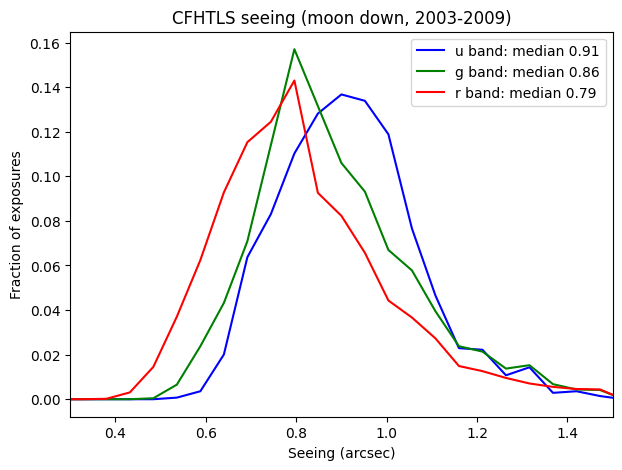

In [63]:
plt.figure(figsize=(7,5))
for f in ['u','g','r']:
    I = np.flatnonzero((T_cfhtls.filter == f) * (T_cfhtls.seeing_center < 1.5))
    med = np.median(T_cfhtls.seeing_center[I])
    print('Median seeing in %s: %.2f' % (f, med))
    n,e = np.histogram(T_cfhtls.seeing_center[I], range=(0.25, 1.55), bins=25)
    plt.plot((e[1:]+e[:-1])/2, n / np.sum(n), '-', color=colormap[f], label='%s band: median %.2f' % (f, med))
    #plt.hist(T_cfhtls.seeing_center[I], range=(0.4, 1.5), bins=22, color=colormap[f], histtype='step', label='%s band' % f);
    #plt.title('CFHTLS, moon down, 2003-2009')
plt.xlabel('Seeing (arcsec)');
plt.xlim(0.3, 1.5)
plt.ylabel('Fraction of exposures')
plt.title('CFHTLS seeing (moon down, 2003-2009)')
plt.legend()
plt.savefig('cfhtls-seeing-1.png');

In [67]:
e

array([0.255, 0.265, 0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335,
       0.345, 0.355, 0.365, 0.375, 0.385, 0.395, 0.405, 0.415, 0.425,
       0.435, 0.445, 0.455, 0.465, 0.475, 0.485, 0.495, 0.505, 0.515,
       0.525, 0.535, 0.545, 0.555, 0.565, 0.575, 0.585, 0.595, 0.605,
       0.615, 0.625, 0.635, 0.645, 0.655, 0.665, 0.675, 0.685, 0.695,
       0.705, 0.715, 0.725, 0.735, 0.745, 0.755, 0.765, 0.775, 0.785,
       0.795, 0.805, 0.815, 0.825, 0.835, 0.845, 0.855, 0.865, 0.875,
       0.885, 0.895, 0.905, 0.915, 0.925, 0.935, 0.945, 0.955, 0.965,
       0.975, 0.985, 0.995, 1.005, 1.015, 1.025, 1.035, 1.045, 1.055,
       1.065, 1.075, 1.085, 1.095, 1.105, 1.115, 1.125, 1.135, 1.145,
       1.155, 1.165, 1.175, 1.185, 1.195, 1.205, 1.215, 1.225, 1.235,
       1.245, 1.255, 1.265, 1.275, 1.285, 1.295, 1.305, 1.315, 1.325,
       1.335, 1.345, 1.355, 1.365, 1.375, 1.385, 1.395, 1.405, 1.415,
       1.425, 1.435, 1.445, 1.455, 1.465, 1.475, 1.485, 1.495, 1.505])

Median seeing in u: 0.91
Median seeing in g: 0.86
Median seeing in r: 0.79


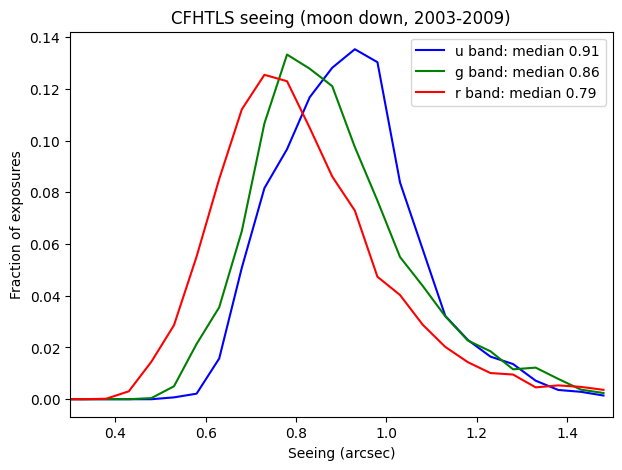

In [73]:
plt.figure(figsize=(7,5))
edges = 0.005 + np.arange(0.25, 1.51, 0.05)
for f in ['u','g','r']:
    I = np.flatnonzero((T_cfhtls.filter == f) * (T_cfhtls.seeing_center < 1.5))
    med = np.median(T_cfhtls.seeing_center[I])
    print('Median seeing in %s: %.2f' % (f, med))
    n,e = np.histogram(T_cfhtls.seeing_center[I], bins=edges)
    plt.plot((e[1:]+e[:-1])/2, n / np.sum(n), '-', color=colormap[f], label='%s band: median %.2f' % (f, med))
    #plt.hist(T_cfhtls.seeing_center[I], range=(0.4, 1.5), bins=22, color=colormap[f], histtype='step', label='%s band' % f);
    #plt.title('CFHTLS, moon down, 2003-2009')
plt.xlabel('Seeing (arcsec)');
plt.xlim(0.3, 1.5)
plt.ylabel('Fraction of exposures')
plt.title('CFHTLS seeing (moon down, 2003-2009)')
plt.legend()
plt.savefig('cfhtls-seeing-1b.png');

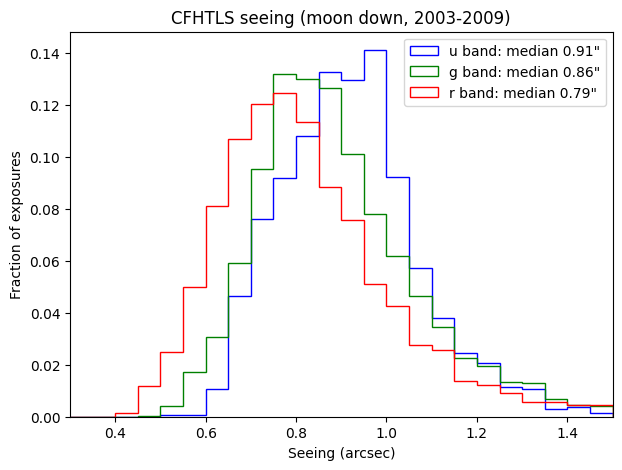

In [64]:
plt.figure(figsize=(7,5))
for f in ['u','g','r']:
    I = np.flatnonzero((T_cfhtls.filter == f) * (T_cfhtls.seeing_center < 1.5))
    med = np.median(T_cfhtls.seeing_center[I])
    plt.hist(T_cfhtls.seeing_center[I], weights=np.ones(len(I))/len(I),
             range=(0.3, 1.5), bins=24, color=colormap[f], histtype='step', label='%s band: median %.2f"' % (f,med));
    #plt.title('CFHTLS, moon down, 2003-2009')
plt.xlabel('Seeing (arcsec)');
plt.xlim(0.3, 1.5)
plt.ylabel('Fraction of exposures')
plt.title('CFHTLS seeing (moon down, 2003-2009)')
plt.legend()
plt.savefig('cfhtls-seeing-2.png');

In [ ]:
#! pip install astroplan

In [ ]:
import astroplan

In [ ]:
times = Time(Tmoon.mjd, format='mjd')# - utcoffset
Tmoon.moon_illum = astroplan.moon_illumination(times)

In [ ]:
kwa = dict(range=(0, 5), bins=50)
I = np.flatnonzero(Tmoon.filter == 'u')
plt.scatter(Tmoon.moon_alt[I], Tmoon.skylevel[I] / Tmoon.exptime[I], c=Tmoon.moon_illum[I], s=8, cmap='Blues', label='u band')
plt.axhline(medu, color='b')
I = np.flatnonzero(Tmoon.filter == 'g')
plt.scatter(Tmoon.moon_alt[I], Tmoon.skylevel[I] / Tmoon.exptime[I], c=Tmoon.moon_illum[I], s=8, cmap='Greens', label='g band')
plt.axhline(medg, color='g')
I = np.flatnonzero(Tmoon.filter == 'r')
#plt.scatter(Tmoon.moon_alt[I], Tmoon.skylevel[I] / Tmoon.exptime[I], c=Tmoon.moon_illum[I], s=8, cmap='Reds', label='r band')
#plt.plot(Tmoon.moon_alt[I], Tmoon.skylevel[I] / Tmoon.exptime[I], '.', color='r', label='r band')
#plt.axhline(medr, color='r')
plt.xlabel('Moon altitude (deg)')
plt.ylabel('Sky background (ADU / second)')
plt.title('All CFHTLS exposures, 2003-2009')
plt.yscale('log')
plt.legend();